In [18]:
#Imports
import PySAM
import PV_ICE
import pandas as pd
import numpy as np
import json
import os
from PySAM import Pvsamv1 as pv
from PySAM import Pvwattsv8 as pvwatts
from PySAM import Cashloan as com
from PySAM import Grid as grid
from PySAM import Utilityrate5 as ur
import PySAM.Pvsamv1Tools as pvtools
import PySAM.ResourceTools as tools

In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("PySAM version ", PySAM.__version__)
print("PV_ICE version ", PV_ICE.__version__)

Working on a  Windows 10
Python version  3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.4
PySAM version  7.0.0
PV_ICE version  0.4.4.dev2+g378a012.d20250320


### C&I Case Study

A commercial building owner seeking advice on what to do with their PV systems as their rooftop ages: decommissioning the system, reinstalling the current setup after roof maintenance, or repowering with newer, more efficient technology


In [15]:
# Set up base case
pv_model = pv.default("FlatPlatePVCommercial")
ur_model = ur.from_existing(pv_model)
grid_model = grid.from_existing(pv_model)
fin_model = com.from_existing(pv_model)

for json_file in os.listdir('commercial_files'):
    # get the inputs from the JSON file
    with open( 'commercial_files/' + json_file, 'r') as f:
            pv_inputs = json.load( f )
    
    # iterate through the input key-value pairs and set the module inputs
    for k, v in pv_inputs.items():
        if k != 'number_inputs':
            print(k)
            try:
                pv_model.value(k, v)
            except:
                try:
                    ur_model.value(k, v)
                except:
                    try:
                        grid_model.value(k, v)
                    except:
                        try:
                            fin_model.value(k, v)
                        except:
                            print("Variable not found in modules")

# grid_model = grid.from_existing(pv_model)
# ur_model = ur.from_existing(pv_model)
# fin_model = com.from_existing(pv_model)


federal_tax_rate
state_tax_rate
property_tax_rate
prop_tax_cost_assessed_percent
prop_tax_assessed_decline
real_discount_rate
insurance_rate
loan_term
loan_rate
debt_fraction
om_fixed
om_fixed_escal
om_production
om_capacity
om_capacity_escal
depr_fed_type
depr_fed_sl_years
depr_fed_custom
depr_sta_type
depr_sta_sl_years
depr_sta_custom
itc_fed_amount
itc_fed_amount_deprbas_fed
itc_fed_amount_deprbas_sta
itc_sta_amount
itc_sta_amount_deprbas_fed
itc_sta_amount_deprbas_sta
itc_fed_percent
itc_fed_percent_maxvalue
itc_fed_percent_deprbas_fed
itc_fed_percent_deprbas_sta
itc_sta_percent
itc_sta_percent_maxvalue
itc_sta_percent_deprbas_fed
itc_sta_percent_deprbas_sta
ptc_fed_amount
ptc_fed_term
ptc_fed_escal
ptc_sta_amount
ptc_sta_term
ptc_sta_escal
ibi_fed_amount
ibi_fed_amount_tax_fed
ibi_fed_amount_tax_sta
ibi_fed_amount_deprbas_fed
ibi_fed_amount_deprbas_sta
ibi_sta_amount
ibi_sta_amount_tax_fed
ibi_sta_amount_tax_sta
ibi_sta_amount_deprbas_fed
ibi_sta_amount_deprbas_sta
ibi_uti_amount


In [19]:
# Download resource data
#Read in weather data from SAM, or use NSRDB downloads in SAM format, or use dictionary of solar data
#A. You already have a file
weather_file = "weather_file.csv"
pv_model.SolarResource.solar_resource_file = weather_file

#B. solar_resource_data
# weather_data = PySAM.ResourceTools.SAM_CSV_to_solar_data(weather_file)
# solar_resource_data = {
#         'tz': tz, # timezone
#         'elev': elev, # elevation
#         'lat': lat, # latitude
#         'lon': lon, # longitude
#         'year': tuple(weather_data[0]), # year
#         'month': tuple(weather_data[1]), # month
#         'day': tuple(weather_data[2]), # day
#         'hour': tuple(weather_data[3]), # hour
#         'minute': tuple(weather_data[4]), # minute
#         'dn': tuple(weather_data[5]), # direct normal irradiance
#         'df': tuple(weather_data[6]), # diffuse irradiance
#         'gh': tuple(weather_data[7]), # global horizontal irradiance
#         'wspd': tuple(weather_data[8]), # windspeed
#         'tdry': tuple(weather_data[9]) # dry bulb temperature
#         }
# pv_model.unassign("solar_resource_file")
# pv_model.SolarResource.solar_resource_data = solar_resource_data

#C. Download from NSRDB
# 
# --- Initialize Solar Resource Fetcher with minimum parameters ---
# See function documentation for full parameter list

#import geocoder

# replace with key and email address from https://developer.nrel.gov/signup/
sam_api_key = os.environ.get('NREL_API_KEY')
sam_email = os.environ.get('NREL_API_EMAIL')
# sam_api_key = nrel_developer_key
# sam_email = sam@email.com
geocode_api_key = ''  # optional, may be required for geocoder

# --- Location Coordinates ---

# Set geocode to True to use geocoding service API
geocode = False
if geocode:
    # See https://geocoder.readthedocs.io/ for different geocoding services
    g = geocoder.bing('golden, co', key=geocode_api_key)
    lon = g.latlng[1]
    lat = g.latlng[0]
else:
    lon = -105.22
    lat = 39.75
nsrdbfetcher = tools.FetchResourceFiles(
                tech='solar',
                nrel_api_key=sam_api_key,
                nrel_api_email=sam_email)

# --- List of (lon, lat) tuples or Shapely points ---
lon_lats = [(lon, lat)]
nsrdbfetcher.fetch(lon_lats)

# --- Get resource data file path ---
nsrdb_path_dict = nsrdbfetcher.resource_file_paths_dict
nsrdb_fp = nsrdb_path_dict[lon_lats[0]]
#pv_model.SolarResource.solar_resource_file = nsrdb_fp


Starting data download for solar using 1 thread workers.
Getting list of available NSRDB files for 39.75, -105.22.
Error for 39.75, -105.22: {
  "error": {
    "code": "API_KEY_INVALID",
    "message": "An invalid api_key was supplied. Get one at https://developer.nrel.gov/signup/"
  }
}


### System Info: Decommissioning case

-Building Height: 1 story

-Mounting Technology: Racking scrap metal salvage value

-Module disposition: Recycle

-Remaining system lifetime: 0 years

-Costs: 25 cents/W

-Labor/Other: 1 day labor for 120-150 modules with a team of 10, Insurance for roofer safety $230/person



In [20]:
# A. Decommissioning case
decommissioning_cost = 0.25 * 1.10 #cents/W, assumed 0.25 for Colorado increased by 10% to California
decommissioning_cost_total = decommissioning_cost * pv_model.SystemDesign.system_capacity * 1000

recycling_cost = 16200
#No generation, no incentives
npv = []
payback_period = []
npv.append(-1 * (decommissioning_cost_total + recycling_cost))
#There is no payback period
payback_period.append(float('nan'))

### System Info: Reinstall case

-Building Height: 1 story

-Mounting Technology: Keep racking

-Module disposition: NA

-Remaining system lifetime: 12 years (user sets)

-Costs: 1.5x the decommissioning cost (estimated)

-Labor/Other: NA



In [21]:
# B. Reinstall case
reinstall_cost = 0.58 #cents/W (modified by user)
reinstall_cost_total = reinstall_cost * pv_model.SystemDesign.system_capacity * 1000

#System specs stay the same
pv_model.execute()
grid_model = grid.from_existing(pv_model)
ur_model = ur.from_existing(pv_model)
fin_model = com.from_existing(pv_model)
grid_model.execute()
ur_model.execute()

#Set system costs
fin_model.SystemCosts.total_installed_cost = reinstall_cost_total
#Optional: modify loan terms
# fin_model.FinancialParameters.debt_fraction = 100 #%
# fin_model.FinancialParameters.loan_term = 12 #years
# fin_model.FinancialParameters.loan_rate = 7 #%/year


fin_model.execute()
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)



### System Info: Repower + scrap case

-Building Height: 1 story

-Mounting Technology: Keep racking

-Module disposition: New module cost + Recycle

-Remaining system lifetime: 30 years (user sets)

-Costs: \\$1/W to \\$2.50/W OR 10-30% adder above greenfield; 
Recycling: $10/panel

-Labor/Other:To not renegotiate, new system size must not be >10% or less than 1kW greaterA



In [48]:
# C. Repower + scrap
repower = pv_model
mod_dict = pvtools.set_cec_module_library_selection(repower, "Aptos Solar Technology LLC DNA-144-BF10-530W")
sys_cap = 504 #kWDC
repower.Lifetime.analysis_period = 30 #years
n_strings, n_combiners, n_inverters, calculated_system_capacity = pvtools.size_electrical_parameters(repower, sys_cap, 1.1)

repower.execute()
grid_model = grid.from_existing(repower)
ur_model = ur.from_existing(repower)
fin_model = com.from_existing(repower)

grid_model.execute()
ur_model.execute()

repower_cost = 2.21 #$/Wdc
repower_cost_total = repower_cost * repower.SystemDesign.system_capacity * 1000
recycle_cost = 16200
total_installed_cost = repower_cost_total + recycle_cost
fin_model.TaxCreditIncentives.itc_fed_amount = [291818] #30%, accounting for depreciation 
fin_model.SystemCosts.total_installed_cost = total_installed_cost
fin_model.execute()
bill_savings = ur_model.Outputs.savings_year1
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)



This function does not set the bifaciality of a module based on the bifacial based on the lib_is_bifacial value. Please change cec_is_bifacial to 1 to make the module bifacial.


### System Info: Repower + resell case

-Building Height: 1 story

-Mounting Technology: Keep racking

-Module disposition: New module cost + Resell

-Remaining system lifetime: 30 years (user sets)

-Costs: \\$1/W to \\$2.50/W OR 10-30% adder above greenfield; 
Resell: \\$0.05-0.6/W (only if >300W)

-Labor/Other:To not renegotiate, new system size must not be >10% or less than 1kW greaterA



In [44]:
# D. Repower + resell
#Run after Repower + scrap case, then no need to re-run performance calculations, only financials

repower_cost = 2.21 #$/Wdc
repower_cost_total = repower_cost * repower.SystemDesign.system_capacity * 1000
recycle_cost = -25210
total_installed_cost = repower_cost_total + recycle_cost
fin_model.SystemCosts.total_installed_cost = total_installed_cost
fin_model.TaxCreditIncentives.itc_fed_amount = [291818] #30%, accounting for depreciation 
fin_model.execute()
bill_savings = ur_model.Outputs.savings_year1
npv.append(fin_model.Outputs.npv)
payback_period.append(fin_model.Outputs.payback)
labels = ["Decommission", "Reinstall", "Repower + scrap", "Repower + resell"]


                  0              1          2
0      Decommission   -154371.3795        NaN
1         Reinstall  547956.448951    2.87441
2   Repower + scrap -142134.859241  10.399999
3  Repower + resell  -108691.04379  10.063694
4               NaN  340023.485216  10.203455
5               NaN  373467.300667   9.871636
6               NaN  340023.485216  10.203455
7               NaN  373467.300667   9.871636
8               NaN  607599.131649   7.808715
9               NaN    641042.9471   7.457562
             labels            npv    payback
0      Decommission   -154371.3795        NaN
1         Reinstall  547956.448951    2.87441
2   Repower + scrap -142134.859241  10.399999
3  Repower + resell  -108691.04379  10.063694
4               NaN  340023.485216  10.203455
5               NaN  373467.300667   9.871636
6               NaN  340023.485216  10.203455
7               NaN  373467.300667   9.871636
8               NaN  607599.131649   7.808715
9               NaN    641042.9471

<Axes: xlabel='labels', ylabel='npv'>

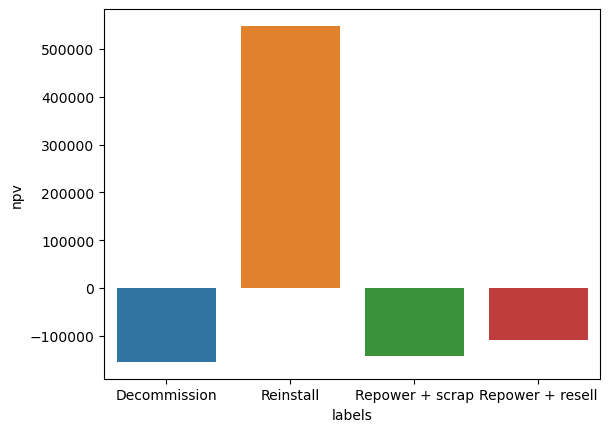

In [45]:
# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data = pd.DataFrame([labels, npv, payback_period])
data = data.transpose()
print(data)
data.columns = ["labels", "npv", "payback"]
print(data)

sns.barplot(data, x="labels", y="npv")


<Axes: xlabel='labels', ylabel='payback'>

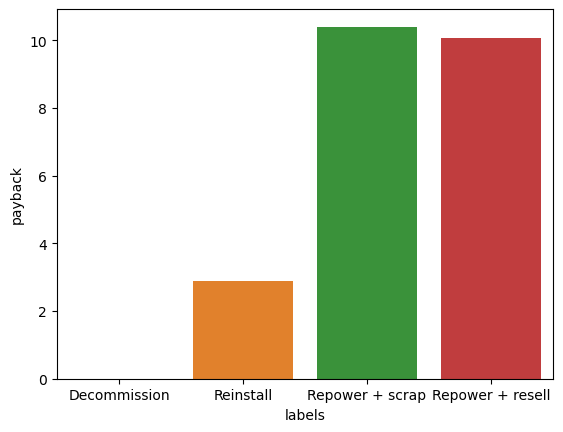

In [47]:
sns.barplot(data, x="labels", y="payback")